Tutorial 4: Bayesian Regularization
===================================

So far, we have:

 - Used pixelizations and mappers to map source-pixels to image-pixels and visa versa.
 - Successfully used an inversion to reconstruct a source.
 - Seen that this reconstruction provides a good fit of the observed image, providing a high likelihood solution.

The explanation of *how* an inversion works has so far been overly simplified. You'll have noted the regularization
inputs which we have not so far discussed. This will be the topic of this tutorial, and where inversions become more
conceptually challenging!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

__Convenience Function__

we're going to perform a lot of fits using an `Inversion` this tutorial. This would create a lot of code, so to keep 
things tidy, I've setup this function which handles it all for us.

(You may notice we include an option to `use_inversion_border, ignore this for now, as we'll be covering borders in 
the next tutorial)

In [3]:


def perform_fit_with_source_galaxy(imaging, source_galaxy):

    mask = al.Mask2D.circular_annular(
        shape_native=imaging.shape_native,
        pixel_scales=imaging.pixel_scales,
        inner_radius=0.3,
        outer_radius=2.6,
    )

    imaging = imaging.apply_mask(mask=mask)

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllIsothermal(
            centre=(0.0, 0.0),
            einstein_radius=1.6,
            elliptical_comps=al.convert.elliptical_comps_from(
                axis_ratio=0.9, angle=45.0
            ),
        ),
        shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(imaging=imaging, tracer=tracer)


__Pixelization__

Okay, so lets look at our fit from the previous tutorial in more detail. we'll use a higher resolution 40 x 40 grid.

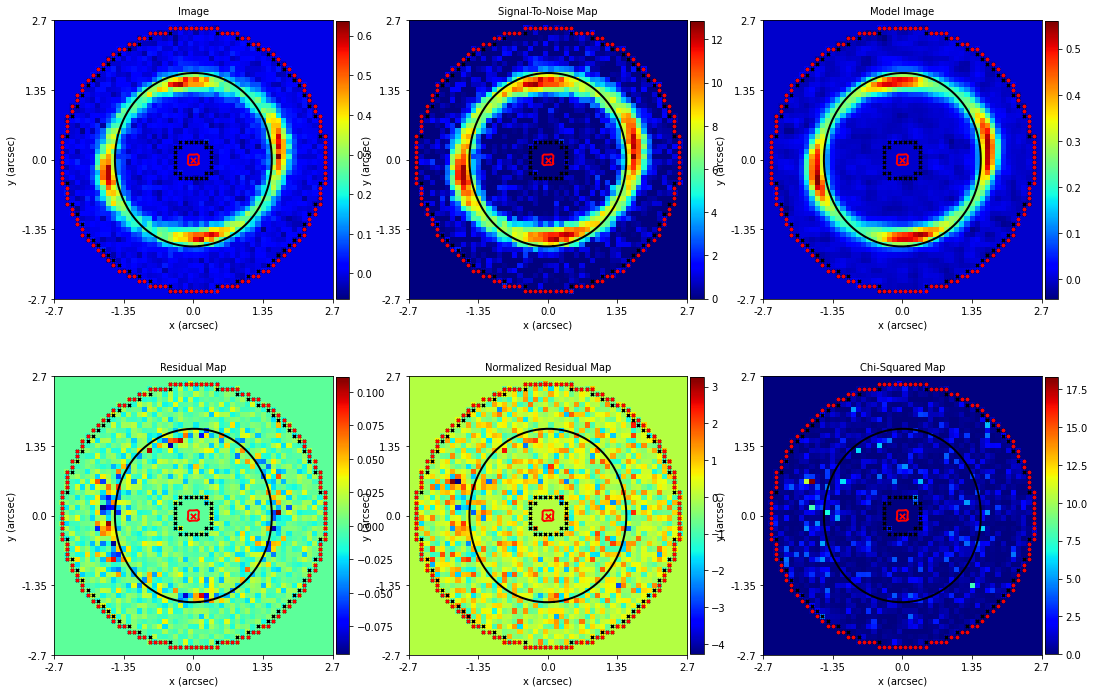

In [4]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_source_galaxy(imaging=imaging, source_galaxy=source_galaxy)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
fit_imaging_plotter.subplot_fit_imaging()

__Regularization__

The source reconstruction looks excellent! 

However, the high quality of this solution was possible because I chose a `coefficient` for the regularization input of
1.0. If we reduce this `coefficient` to zero, the source reconstruction goes *very* weird.

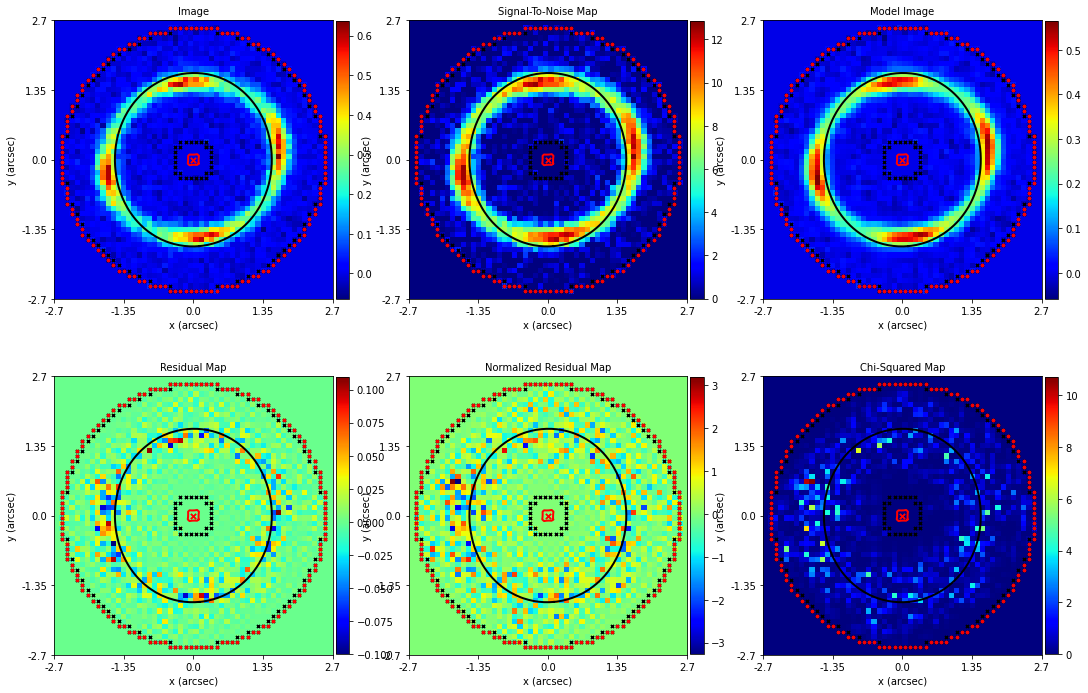

In [5]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=0.0),
)

no_regularization_fit = perform_fit_with_source_galaxy(
    imaging=imaging, source_galaxy=source_galaxy
)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=no_regularization_fit, include_2d=include_2d
)
fit_imaging_plotter.subplot_fit_imaging()

So, what is happening here? Why does reducing the `coefficient` do this to our source reconstruction? First, we need
to understand what regularization actually does!

When the inversion reconstructs the source, it does not *only* compute the set of source-pixel fluxes that best-fit 
the image. It also regularizes this solution, whereby it goes to every pixel on the rectangular source-plane grid 
and computes the different between the reconstructed flux values of every source pixel with its 4 neighboring pixels. 
If the difference in flux is large the solution is penalized, reducing its log likelihood. You can think of this as 
us applying a 'smoothness prior' on the reconstructed source galaxy's light.

This smoothing adds a 'penalty term' to the log likelihood of an inversion which is the summed difference between the 
reconstructed fluxes of every source-pixel pair multiplied by the `coefficient`. By setting the regularization 
coefficient to zero, we set this penalty term to zero, meaning that regularization is completely omitted.

Why do we need to regularize our solution? We just saw why, if we do not apply this smoothness prior to the source, we 
`over-fit` the image and reconstruct a noisy source with lots of extraneous features. This is what the  large flux 
values located at the exterior regions of the source reconstruction above are. If the inversions's sole aim is to 
maximize the log likelihood, it can do this by fitting *everything* accurately, including the noise.

If we change the `vmax` and `vmin` variables of the `Plotter`'s `CMap` such that the color-map is restricted to a 
narrower range of values, we can see that even without regularization we are still reconstructing the actual source 
galaxy.

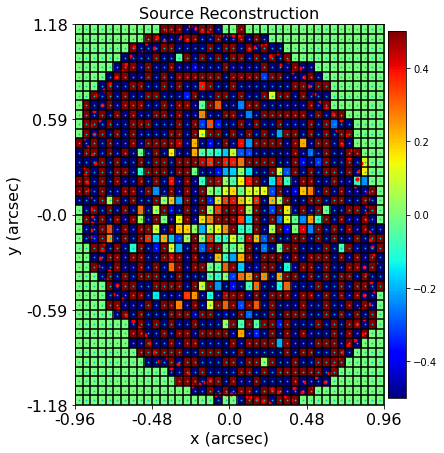

In [6]:
mat_plot_2d = aplt.MatPlot2D(cmap=aplt.Cmap(vmax=0.5, vmin=-0.5))

inversion_plotter = aplt.InversionPlotter(
    inversion=no_regularization_fit.inversion, mat_plot_2d=mat_plot_2d
)
inversion_plotter.figures_2d(reconstruction=True)

Over-fitting is why regularization is necessary. Solutions like this will completely ruin our attempts to model a 
strong lens. By smoothing our source reconstruction we ensure it does not over fit noise in the image. 

So, what happens if we apply a high value for the regularization coefficient?

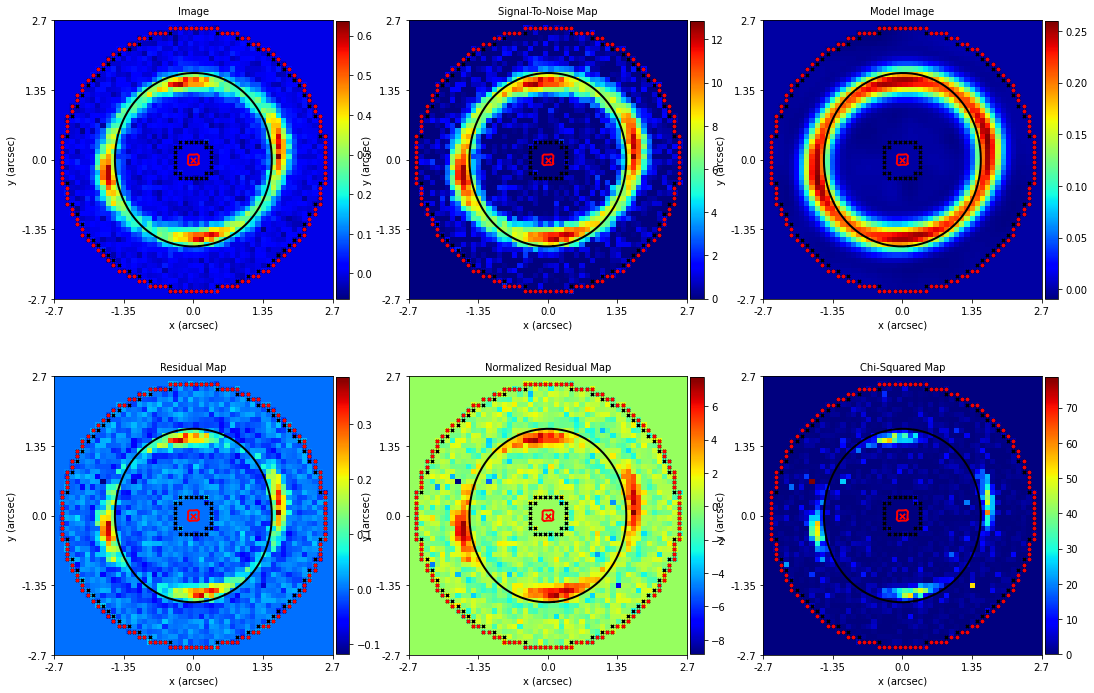

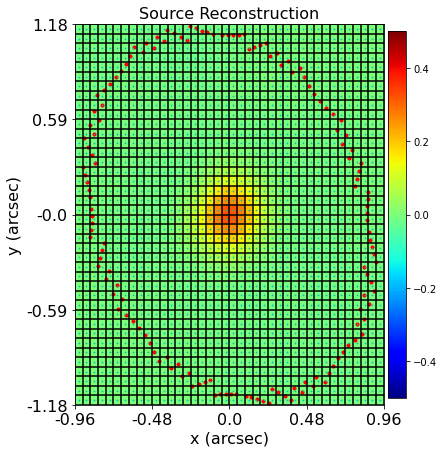

In [7]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=100.0),
)

high_regularization_fit = perform_fit_with_source_galaxy(
    imaging=imaging, source_galaxy=source_galaxy
)

fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=high_regularization_fit, include_2d=include_2d
)
fit_imaging_plotter.subplot_fit_imaging()

inversion_plotter = aplt.InversionPlotter(
    inversion=high_regularization_fit.inversion, mat_plot_2d=mat_plot_2d
)
inversion_plotter.figures_2d(reconstruction=True)

The figure above shows that we completely remove over-fitting. However, we now fit the image data less accurately,
due to the much higher level of smoothing.

So, we now understand what regularization is and why it is necessary. There is one nagging question that remains, how 
do I choose the regularization coefficient value? We can not use the log likelihood, as decreasing the regularization
coefficient will always increase the log likelihood, because less smoothing allows the source reconstruction to fit 
the data better.

In [8]:
print("Likelihood Without Regularization:")
print(no_regularization_fit.log_likelihood_with_regularization)
print("Likelihood With Normal Regularization:")
print(fit.log_likelihood_with_regularization)
print("Likelihood With High Regularization:")
print(high_regularization_fit.log_likelihood_with_regularization)

Likelihood Without Regularization:
5664.812418535763
Likelihood With Normal Regularization:
5334.046650119836
Likelihood With High Regularization:
1684.378216514824


__Bayesian Evidence__

For inversions, we therefore need a different goodness-of-fit measure to choose the appropriate level of regularization. 

For this, we invoke the `Bayesian Evidence`, which quantifies the goodness of the fit as follows:

 - It requires that the residuals of the fit are consistent with Gaussian noise (which is the type of noise expected 
 in the imaging data). If this Gaussian pattern is not visible in the residuals, the noise must have been over-fitted
 by the inversion. The Bayesian evidence will therefore decrease. If the image is fitted poorly due to over smoothing, 
 the residuals will again not appear Gaussian either, again producing a decrease in the Bayesian evidence value.

 - There can be many solutions which fit the data to the noise level, without over-fitting. To determine the best 
 solutions from these solutions, the Bayesian evidence therefore also quantifies the complexity of the source 
 reconstruction. If an inversion requires many pixels and a low level of regularization to achieve a good fit, the 
 Bayesian  evidence will decrease. The evidence penalizes solutions which are complex, which, in a Bayesian sense, are 
 less probable (you may want to look up `Occam`s Razor`).

The Bayesian evidence therefore ensures we only invoke a more complex source reconstruction when the data absolutely 
necessitates it.

Lets take a look at the Bayesian evidence of the fits that we performed above, which is accessible from a `FitImaging` 
object via the `log_evidence` property:

In [9]:
print("Bayesian Evidence Without Regularization:")
print(no_regularization_fit.log_evidence)
print("Bayesian Evidence With Normal Regularization:")
print(fit.log_evidence)
print("Bayesian Evidence With High Regularization:")
print(high_regularization_fit.log_evidence)

Bayesian Evidence Without Regularization:
-6121.5671840916875
Bayesian Evidence With Normal Regularization:
4068.9764301755886
Bayesian Evidence With High Regularization:
1641.0545365435592


As expected, the solution that we could see `by-eye` was the best solution corresponds to the highest log evidence 
solution.

__Non-Linear and Linear__

Before we end, lets consider which aspects of an inversion are linear and which are non-linear.

The linear part of the inversion is the step that solves for the reconstruct source pixel fluxes, including accounting
for the smoothing via regularizaton. We do not have to perform a non-linear search to determine the source-pixel
fluxes or compute the Bayesian evidence discussed above.

However, determining the regularization `coefficient` that maximizes the Bayesian log evidence is a non-linear problem 
that requires a non-linear search. The Bayesian evidence also depends on the source grid resolution, which means the 
pixel-grid's `shape` parameter may also now become dimensions of non linear parameter space. Nevertheless, these total 
only 3 non-linear parameters, far fewer than the 20+ that are required when modeling sources uses light profiles! 

Here are a few questions for you to think about.

 1) We maximize the log evidence by using simpler source reconstructions. Therefore, decreasing the pixel-grid 
 size should provide a higher log_evidence, provided it still has sufficiently high resolution to fit the image well 
 (and provided that the regularization coefficient is set to an appropriate value). Can you increase the log evidence 
 from the value above by changing these parameters, I've set you up with a code to do so below.

Previous Bayesian Evidence:
3988.0716851250163
New Bayesian Evidence:
4068.9764301755886


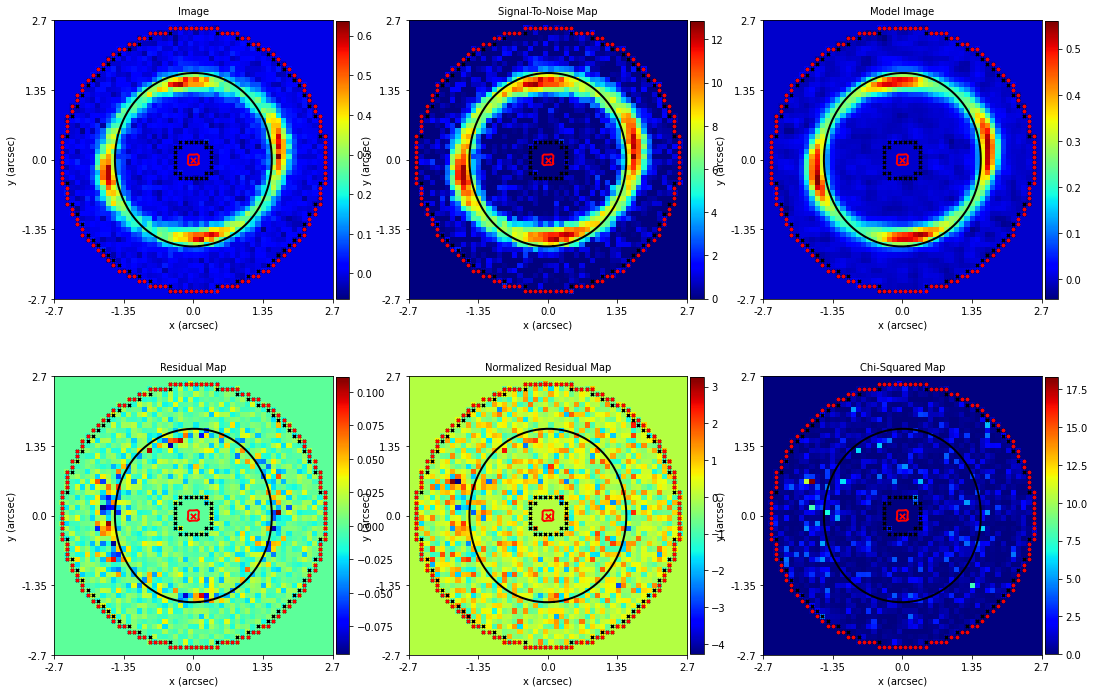

In [10]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_source_galaxy(imaging=imaging, source_galaxy=source_galaxy)

print("Previous Bayesian Evidence:")
print(3988.0716851250163)
print("New Bayesian Evidence:")
print(fit.log_evidence)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

 2) Can you think of any other ways we might increase the Bayesian evidence even further? In future tutorials we will 
 learn how **PyAutoLens** can adapts the source reconstructions to the properties of the image so as to maximize the 
 Bayesian evidence!
 
__Detailed Description__

Below, I provide a more detailed discussion of the Bayesian evidence. It is not paramount that you understand this to
use **PyAutoLens**, but I recommend you give it a read to get an intuition for how the evidence works.

The Bayesian log evidence quantifies the following 3 aspects of a fit to strong lens imaging data:

1) *The quality of the image reconstruction:*  The source reconstruction is a linear inversion which uses the observed
 values in the image-data to fit it and reconstruct the source. It is in principle able to perfectly reconstruct the
 image regardless of the image’s noise or the accuracy of the lens model (e.g. at infinite source resolution without
 regularization). The problem is therefore ‘ill-posed’ and this is why regularization is necessary.

 However, this raises the question of what constitutes a ‘good’ solution? The Bayesian evidence defines this by
 assuming that the image data consists of independent Gaussian noise in every image pixel. A ‘good’ solution is one
 whose chi-squared residuals are consistent with Gaussian noise, producing a reduced chi-squared near 1.0 .Solutions
 which give a reduced chi squared below 1 are penalized for being overly complex and fitting the image’s noise, whereas
 solutions with a reduced chi-squared above are penalized for not invoking a more complex source model when the data it
 is necessary to fit the data bettter. In both circumstances, these penalties reduce the inferred Bayesian evidence!

2) *The complexity of the source reconstruction:* The log evidence estimates the number of source pixels that are used 
 to reconstruct the image, after accounting for their correlation with one another due to regularization. Solutions that
 require fewer correlated source pixels increase the Bayesian evidence. Thus, simpler and less complex source 
 reconstructions are favoured.

3) *The signal-to-noise (S/N) of the image that is fitted:* The Bayesian evidence favours models which fit higher S/N
 realizations of the observed data (where the S/N is determined using the image-pixel variances, e.g. the noise-map). Up 
 to now, all **PyAutoLens** fits assumed fixed variances, meaning that this aspect of the Bayeisan evidence has no impact 
 on the inferred evidence values. However, in hyper-mode we will invoke functionality that increases the variances 
 of image-pixels where the lens model fits the data poorly.
   
 The premise is that whilst increasing the variances of image pixels lowers their S/N values and therefore also
 decreases the log evidence, doing so may produce a net increase in log evidence. This occurs when the chi-squared 
 values of the image pixels whose variances are increased were initially very high (e.g. they were fit poorly by the 
 lens model).

In summary, the log evidence is maximized for solutions which most accurately reconstruct the highest S/N realization of
the observed image, without over-fitting its noise and using the fewest correlated source pixels. By employing this
framework throughout, **PyAutoLens** objectively determines the final lens model following the principles of Bayesian
analysis and Occam’s Razor.